In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
import torchvision
import torchvision.transforms as transforms

from skimage import io, transform

In [4]:
import matplotlib.pyplot as plt

In [5]:
import sys
import numpy as np
import random

## Load Data

In [6]:
path =  '../Preprocessing/Data/'

In [7]:
img_data = np.load(path + 'img_data.npy')
img_label = np.load(path + 'img_age.npy')

In [9]:
print('Data Shape \n')

print(img_data.shape)
print(img_label.shape)

Data Shape 

(2700, 7, 512, 384, 3)
(2700, 7, 1)


## Reshape

In [10]:
height = 512
width = 384
channel = 3
a_class = 3

In [11]:
img_data = img_data.reshape(-1 , height , width , channel)
img_label = img_label.reshape(-1,)

In [12]:
print('Data Shape\n')

print(img_data.shape)
print(img_label.shape)

Data Shape

(18900, 512, 384, 3)
(18900,)


In [13]:
img_size = 256
batch_size = 32

mid_h = int(height/2)
mid_w = int(width/2)
mid_s = int(img_size/2)

# crop image of center : image shape (18900 , 256 , 256 , 3)
img_data = img_data[: , 
                    mid_h - mid_s : mid_h + mid_s , 
                    mid_w - mid_s : mid_w + mid_s ,
                    :]

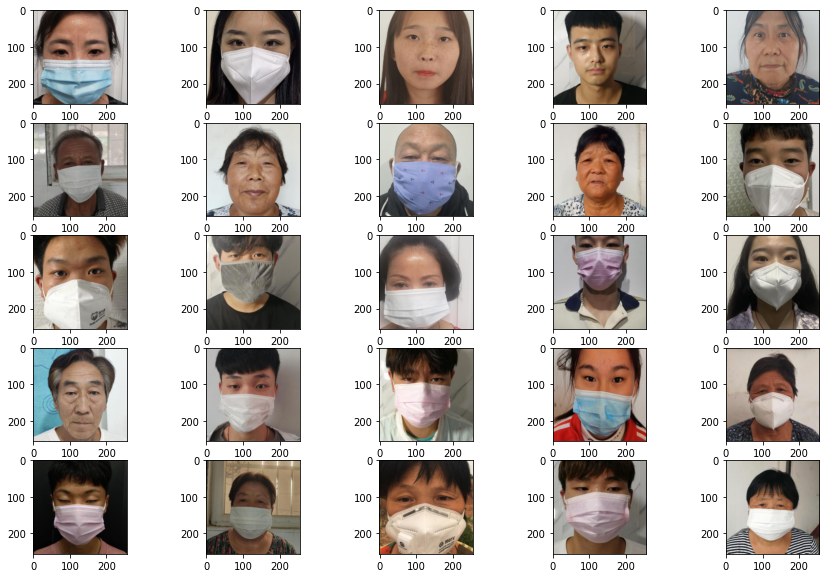

In [14]:
fig , axes = plt.subplots(5 , 5 , figsize = (15 , 10))

rand_idx = np.random.choice(len(img_data) , 25 , replace = False)
idx = 0

for i in range(5) :
    for j in range(5) :
       
        jdx = rand_idx[idx]
        axes[i][j].imshow(img_data[jdx])
        
        idx += 1

In [22]:
class ProjectDataset(Dataset) :

    def __init__(self , data , label , class_size) :

        super(Dataset , self).__init__()

        self.data = np.transpose(data , (0,3,1,2)) # change channel first (for pytorch)
        self.label = np.eye(class_size)[img_label.astype('int32')] # one hot vector

    def __len__(self) :

        data_len = self.data.shape[0]

        return data_len

    def __getitem__(self , idx) :

        data_idx = self.data[idx]
        label_idx = self.label[idx]
        
        # return dict type
        sample_idx = {'image' : data_idx , 'label' : label_idx}
        
        return sample_idx

In [29]:
class CutMix(object):
    
    def __init__(self, img_height , img_width):
        
        self.h = img_height
        self.w = img_width 
        
        # combination rate sampled from the uniform distribution
        self.gen = torch.distributions.beta.Beta(1,1)
        
    def __call__(self, sample):
        
        # org image
        a_image, a_label = sample['image'], sample['label']
        
        batch_size = len(a_image)
        rand = torch.randperm(batch_size)
        
        # image which we will take patch
        b_image = a_image[rand]
        b_label = a_label[rand]
        
        # y , x point of patch
        y = torch.randint(self.h , (1,))[0]
        x = torch.randint(self.w, (1,))[0]

        # combination ratio
        r = self.gen.sample()
        
        # height and width of patch
        h = (self.h * torch.sqrt(1-r)).int()
        w = (self.w * torch.sqrt(1-r)).int()

        # org image(a) + image patch(b)
        c_image = a_image.clone()
        c_image[: , : , y:y+h , x:x+w] = b_image[: , : ,y:y+h , x:x+w]
        
        # combine label
        c_label = a_label * r + b_label * (1-r)
        
        return {'image' : c_image , 'label' : c_label}

In [30]:
img_dset = ProjectDataset(img_data , img_label , a_class)

img_loader = DataLoader(img_dset , 
                        batch_size = 32 ,
                        shuffle = True , 
                        num_workers = 4)

In [31]:
for data_dict in img_loader :
    
    break

In [42]:
cutmix = CutMix(img_size , img_size)

In [53]:
cutmix_dict = cutmix(data_dict)

cutmix_img , cutmix_label = cutmix_dict['image'] , cutmix_dict['label']

## Check Cutmixex Image

In [54]:
cutmix_array = cutmix_img.detach().cpu().numpy()

cutmix_array = np.transpose(cutmix_array , (0,2,3,1))

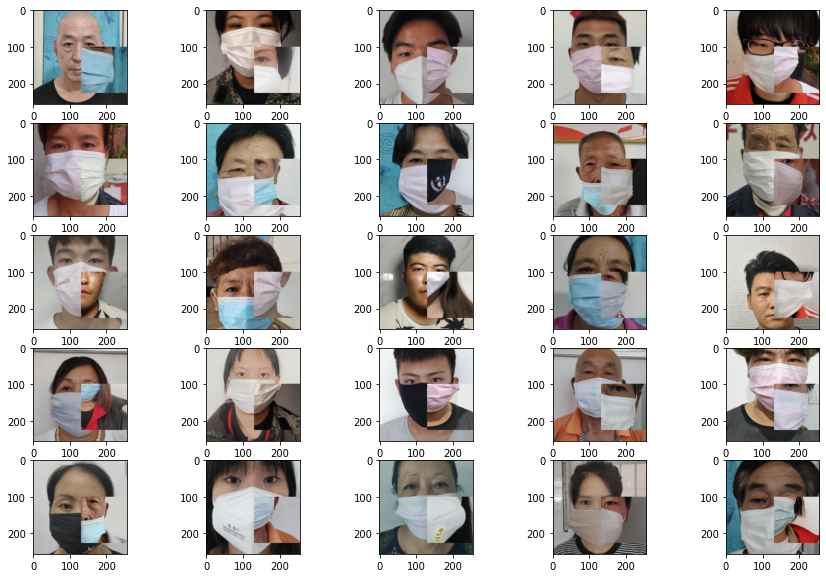

In [55]:
fig , axes = plt.subplots(5 , 5 , figsize = (15 , 10))

idx = 0

for i in range(5) :
    for j in range(5) :
       
        axes[i][j].imshow(cutmix_array[idx])
        idx += 1

## Check Combined Label

In [56]:
cutmix_label

tensor([[0.0000, 1.0000, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.2424, 0.7576, 0.0000],
        [0.0000, 0.2424, 0.7576],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.2424, 0.7576, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.2424, 0.7576, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [0.7576, 0.0000, 0.2424],
        [0.7576, 0.2424, 0.0000],
        [0.2424, 0.7576, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.2424, 0.7576, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [0.7576, 0.2424, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.242